### Imports

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from nltk import jaccard_distance
from nltk.tokenize import word_tokenize

### Dataset

In [298]:
df = pd.read_json('data/News_Category_Dataset_v3.json', lines=True)

In [299]:
#dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [300]:
df.shape

(209527, 6)

In [301]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [302]:
cols= df.columns.to_list()
cols

['link', 'headline', 'category', 'short_description', 'authors', 'date']

In [303]:
df["date"].describe()

count                  209527
unique                   3890
top       2014-03-25 00:00:00
freq                      100
first     2012-01-28 00:00:00
last      2022-09-23 00:00:00
Name: date, dtype: object

In [304]:
#Selecting data for latest 5 Years 
df = df[df["date"]<="2017-01-01"]

In [308]:
#export 
df.to_csv("data/News_Category_Dataset_v3.csv")

In [188]:
#Removing unnecessary columns
df.drop(["link","authors"],axis=1,inplace=True)

In [189]:
#Catrgories
print(f"Total Unique Catrgories are: {df['category'].nunique()}")
print("\n")
print(f"Total Catrgories are: {df['category'].unique()}")

Total Unique Catrgories are: 40


Total Catrgories are: ['POLITICS' 'THE WORLDPOST' 'CRIME' 'ENTERTAINMENT' 'BLACK VOICES'
 'PARENTS' 'HEALTHY LIVING' 'TECH' 'RELIGION' 'WOMEN' 'WEIRD NEWS'
 'BUSINESS' 'MEDIA' 'GREEN' 'SCIENCE' 'TRAVEL' 'TASTE' 'WORLDPOST' 'STYLE'
 'ARTS' 'LATINO VOICES' 'COLLEGE' 'IMPACT' 'QUEER VOICES' 'GOOD NEWS'
 'EDUCATION' 'COMEDY' 'ARTS & CULTURE' 'SPORTS' 'FIFTY' 'WELLNESS'
 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE' 'WEDDINGS'
 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


In [190]:
#WORD COLUD FUNCTION
def WCplot(cl):
    colData = df[cl]
    singletxt = ''
    for mem in colData:
        singletxt += str(mem)
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(singletxt)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

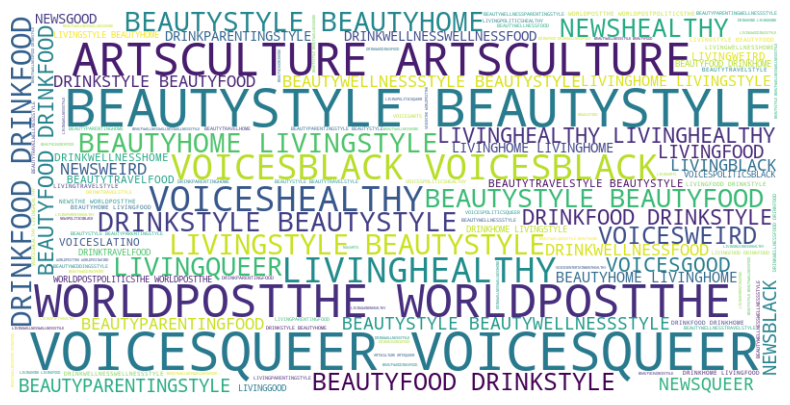

In [275]:
WCplot("category")

In [276]:
df['category'].value_counts()

POLITICS          19075
WELLNESS          17827
ENTERTAINMENT     11157
STYLE & BEAUTY     9649
TRAVEL             9571
PARENTING          8677
FOOD & DRINK       6226
BUSINESS           5446
HEALTHY LIVING     5246
QUEER VOICES       4429
HOME & LIVING      4195
SPORTS             4110
WEDDINGS           3651
COMEDY             3581
DIVORCE            3426
BLACK VOICES       3160
IMPACT             3065
CRIME              2785
PARENTS            2692
THE WORLDPOST      2589
WORLDPOST          2566
WOMEN              2324
RELIGION           2163
GREEN              2051
SCIENCE            2044
WEIRD NEWS         1985
TECH               1901
MEDIA              1890
MONEY              1707
STYLE              1691
TASTE              1557
ARTS               1507
FIFTY              1399
GOOD NEWS          1373
ENVIRONMENT        1323
COLLEGE            1086
CULTURE & ARTS     1030
ARTS & CULTURE      803
LATINO VOICES       745
EDUCATION           741
Name: category, dtype: int64

### Text Preprocessing

In [277]:
#Function to convert text to vectors
def T2V(new_text,raw_df,colname=None):
    vectorizer = TfidfVectorizer(stop_words = "english")
    vectors = vectorizer.fit_transform(raw_df[colname])
    print("Shape of tfidf matrix: {}".format(vectors.shape))
    new_text = [new_text]
    new_text_vector = vectorizer.transform(new_text)
    return vectors, new_text_vector


## Cosine Similarity

In [278]:
def cosine_sm(new_text,raw_df,colname=None):
    T2V(new_text,raw_df,colname)
    score_sm = cosine_similarity(X = vectors, Y = new_text_vector)
    ind = np.argsort(score_sm,axis = 0)[::-1][:10]
    dict01={}
    for i in ind:
        dict01[str(i)]=str(raw_df[colname].tolist()[i[0]])
    dff = pd.DataFrame(list(dict01.items()),columns=["Id",colname])
    return dff

In [279]:
cosine_sm(new_text= "this is new task" , raw_df=df, colname='short_description')

Shape of tfidf matrix: (162443, 68793)


,Id,short_description
0,[133139],"Ne-Yo first performed his hit single, ""Let Me ..."
1,[123656],"The sun is out just a little bit later, we're ..."
2,[39006],NBC has shared an early glimpse of the highly ...
3,[145965],"In fact, under part of Beaver Lake lies the re..."
4,[54108],"In Greek ""ne"" means ""yes."" You'd think it woul..."
5,[114267],"In the Netherlands, the idea of ""Unique and Bo..."
6,[149331],ne of the best deals are that's rarely talked ...
7,[140955],"Ce ne sont pas des ""islamistes"" qui se sont dé..."
8,[54149],
9,[54148],"Block Island calls itself the ""Last Great Plac..."


### Manhattan Distance

In [267]:
def manhattan_sm(new_text, raw_df, colname=None):
   global ind,l1,l2
   T2V(new_text,raw_df,colname)
   score_sm = manhattan_distances(new_text_vector, vectors)
   ind = score_sm.argsort()[:, :10]
   l1,l2=[],[]
   for i in ind[0]:
      try:
         l2.append(str(raw_df[colname].loc[i]))
         l1.append(str(i)) 
      except:
         pass
   dff = pd.DataFrame([l1,l2])
   dff=dff.T
   dff.rename(columns={0:"Id",1:colname},inplace=True)
   return dff

In [287]:
manhattan_sm(new_text= "The earth just had a" , raw_df=df, colname='short_description')

Shape of tfidf matrix: (162443, 68793)


,Id,short_description
0,62110,The royal showed the world how quick and easy ...
1,75448,The earth just had a terrible day in court.
2,75447,Donald Trump held his last rally before the Ne...
3,75446,The senator's supporters are now just making u...
4,75445,"Hold up, did Gregg Popovich just giggle?"
5,75444,"""Who do you think has cuter supporters? Hillar..."
6,75442,"The two faced off on foreign policy, health ca..."
7,75449,"For the past 15 years, Afro-Colombian fashion ..."
8,75439,Welcome to the HuffPost Rise Morning Newsbrief...
9,75437,"""Here is the beginning of my plan to usher us ..."


### Euclidian Distance

In [288]:
def euclidean_sm(new_text, raw_df, colname=None):
   global ind,l1,l2
   T2V(new_text,raw_df,colname)
   score_sm = euclidean_distances(new_text_vector, vectors)
   ind = score_sm.argsort()[:, :10]
   l1,l2=[],[]
   for i in ind[0]:
      try:
         l2.append(str(raw_df[colname].loc[i]))
         l1.append(str(i)) 
      except:
         pass
   dff = pd.DataFrame([l1,l2])
   dff=dff.T
   dff.rename(columns={0:"Id",1:colname},inplace=True)
   return dff

In [289]:
euclidean_sm(new_text= "The Affordable Act" , raw_df=df, colname='short_description')

Shape of tfidf matrix: (162443, 68793)


,Id,short_description
0,133139,The Affordable Care Act demonstrates an affirm...
1,86064,Coleman is the third deaf player in NFL history
2,75222,"In the early-morning hours of February 15, 201..."
3,64136,"Meet Lucky Seven, your new favorite TV persona..."
4,86066,"In his quiet, modest way, Glenn was proud of h..."
5,86067,Killings by police that unleashed a new protes...
6,86068,A Republican National Committee conference cal...
7,86069,A suburban Chicago school's battle heats up.
8,86070,CNN's coverage of the former Laker hits a snag.
9,64135,A new amendment would broaden the FBI's author...


## Jaccard Similarity

In [ ]:
def jaccard_sm(new_text, raw_df, colname=None):
    new_text_tokens = set(word_tokenize(new_text))
    raw_text_tokens = [set(word_tokenize(text)) for text in raw_df[colname]]
    score_sm = [len(new_text_tokens.intersection(text)) / len(new_text_tokens.union(text)) for text in raw_text_tokens]
    ind = np.argsort(score_sm)[::-1][:10]
    dict01 = {}
    for i in ind:
        dict01[str(i)] = str(raw_df[colname].tolist()[i])
    dff = pd.DataFrame(list(dict01.items()), columns=["Id", colname])
    return dff

In [ ]:
jaccard_sm(new_text= "this is new task" , raw_df=df, colname='short_description')

,Id,short_description
0,123419,"Well, this is new."
1,37761,"Well, this is new."
2,41231,"Well, this is new."
3,8443,Well this is win-win.
4,130911,How genius is this?
5,135325,How cool is this?
6,21229,What is this sorcery?
7,38554,"Well, this is awkward."
8,27294,Why is this not surprising?
9,136195,"Yes, this is real."
